CSC with a Spatial Mask
=======================

This example demonstrates the use of [cbpdn.ConvBPDNMaskDcpl](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDNMaskDcpl) for convolutional sparse coding with a spatial mask [[20]](http://sporco.rtfd.org/en/latest/zreferences.html#heide-2015-fast). The example problem is inpainting of randomly distributed corruption of a greyscale image.

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco.admm import tvl2
from sporco.admm import cbpdn
from sporco import util
from sporco import metric
from sporco import plot
plot.config_notebook_plotting()

Load a reference image.

In [2]:
img = util.ExampleImages().image('monarch.png', zoom=0.5, scaled=True,
                                 gray=True, idxexp=np.s_[:, 160:672])

Create random mask and apply to reference image to obtain test image. (The call to ``numpy.random.seed`` ensures that the pseudo-random noise is reproducible.)

In [3]:
np.random.seed(12345)
frc = 0.5
msk = util.rndmask(img.shape, frc, dtype=np.float32)
imgw = msk * img

Define pad and crop functions.

In [4]:
pn = 8
spad = lambda x:  np.pad(x, pn, mode='symmetric')
zpad = lambda x:  np.pad(x, pn, mode='constant')
crop = lambda x: x[pn:-pn, pn:-pn]

Construct padded mask and test image.

In [5]:
mskp = zpad(msk)
imgwp = spad(imgw)

$\ell_2$-TV denoising with a spatial mask as a non-linear lowpass filter. The highpass component is the difference between the test image and the lowpass component, multiplied by the mask for faster convergence of the convolutional sparse coding (see [[40]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2017-convolutional3)).

In [6]:
lmbda = 0.05
opt = tvl2.TVL2Denoise.Options({'Verbose': False, 'MaxMainIter': 200,
                    'DFidWeight': mskp, 'gEvalY': False,
                    'AutoRho': {'Enabled': True}})
b = tvl2.TVL2Denoise(imgwp, lmbda, opt)
sl = b.solve()
sh = mskp * (imgwp - sl)

Load dictionary.

In [7]:
D = util.convdicts()['G:8x8x128']

Set up [admm.cbpdn.ConvBPDNMaskDcpl](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDNMaskDcpl) options.

In [8]:
lmbda = 2e-2
opt = cbpdn.ConvBPDNMaskDcpl.Options({'Verbose': True, 'MaxMainIter': 200,
                    'HighMemSolve': True, 'RelStopTol': 3e-2,
                    'AuxVarObj': False, 'RelaxParam': 1.8,
                    'rho': 5e1*lmbda + 1e-1, 'AutoRho': {'Enabled': False,
                    'StdResiduals': False}})

Construct [admm.cbpdn.ConvBPDNMaskDcpl](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDNMaskDcpl) object and solve.

In [9]:
b = cbpdn.ConvBPDNMaskDcpl(D, sh, lmbda, mskp, opt=opt)
X = b.solve()

Itn   Fnc       DFid      Regℓ1     r         s         
------------------------------------------------------


   0  3.31e+01  2.91e-02  1.66e+03  1.34e-01  1.07e+00


   1  2.84e+01  1.64e-01  1.41e+03  1.20e-01  1.25e+00


   2  2.66e+01  2.80e-01  1.32e+03  1.13e-01  1.13e+00


   3  2.60e+01  3.55e-01  1.28e+03  1.08e-01  9.49e-01


   4  2.52e+01  4.14e-01  1.24e+03  1.04e-01  8.04e-01


   5  2.48e+01  4.62e-01  1.22e+03  9.78e-02  6.91e-01


   6  2.46e+01  5.06e-01  1.21e+03  9.26e-02  5.96e-01


   7  2.46e+01  5.48e-01  1.20e+03  8.79e-02  5.18e-01


   8  2.46e+01  5.90e-01  1.20e+03  8.37e-02  4.54e-01


   9  2.45e+01  6.26e-01  1.19e+03  8.01e-02  3.99e-01


  10  2.44e+01  6.59e-01  1.18e+03  7.69e-02  3.54e-01


  11  2.41e+01  6.89e-01  1.17e+03  7.40e-02  3.18e-01


  12  2.39e+01  7.17e-01  1.16e+03  7.14e-02  2.90e-01


  13  2.36e+01  7.43e-01  1.14e+03  6.91e-02  2.71e-01


  14  2.34e+01  7.68e-01  1.13e+03  6.70e-02  2.58e-01


  15  2.31e+01  7.89e-01  1.12e+03  6.50e-02  2.49e-01


  16  2.29e+01  8.08e-01  1.11e+03  6.32e-02  2.43e-01


  17  2.27e+01  8.25e-01  1.09e+03  6.16e-02  2.37e-01


  18  2.26e+01  8.41e-01  1.09e+03  5.99e-02  2.32e-01


  19  2.25e+01  8.57e-01  1.08e+03  5.85e-02  2.27e-01


  20  2.24e+01  8.74e-01  1.08e+03  5.71e-02  2.23e-01


  21  2.22e+01  8.91e-01  1.06e+03  5.57e-02  2.20e-01


  22  2.19e+01  9.10e-01  1.05e+03  5.43e-02  2.17e-01


  23  2.15e+01  9.30e-01  1.03e+03  5.29e-02  2.13e-01


  24  2.11e+01  9.52e-01  1.01e+03  5.15e-02  2.10e-01


  25  2.06e+01  9.74e-01  9.82e+02  5.02e-02  2.06e-01


  26  2.02e+01  9.95e-01  9.60e+02  4.90e-02  2.02e-01


  27  1.98e+01  1.02e+00  9.41e+02  4.78e-02  1.98e-01


  28  1.95e+01  1.04e+00  9.24e+02  4.67e-02  1.94e-01


  29  1.92e+01  1.06e+00  9.10e+02  4.56e-02  1.90e-01


  30  1.90e+01  1.07e+00  8.98e+02  4.46e-02  1.85e-01


  31  1.88e+01  1.09e+00  8.88e+02  4.37e-02  1.81e-01


  32  1.87e+01  1.10e+00  8.78e+02  4.28e-02  1.77e-01


  33  1.85e+01  1.12e+00  8.70e+02  4.19e-02  1.73e-01


  34  1.84e+01  1.13e+00  8.63e+02  4.11e-02  1.69e-01


  35  1.83e+01  1.14e+00  8.57e+02  4.04e-02  1.66e-01


  36  1.82e+01  1.15e+00  8.51e+02  3.97e-02  1.62e-01


  37  1.80e+01  1.16e+00  8.44e+02  3.90e-02  1.59e-01


  38  1.79e+01  1.17e+00  8.37e+02  3.83e-02  1.56e-01


  39  1.77e+01  1.18e+00  8.28e+02  3.77e-02  1.54e-01


  40  1.75e+01  1.19e+00  8.18e+02  3.70e-02  1.52e-01


  41  1.74e+01  1.20e+00  8.08e+02  3.64e-02  1.50e-01


  42  1.72e+01  1.21e+00  7.99e+02  3.58e-02  1.47e-01


  43  1.70e+01  1.21e+00  7.91e+02  3.52e-02  1.45e-01


  44  1.69e+01  1.22e+00  7.85e+02  3.46e-02  1.43e-01


  45  1.68e+01  1.23e+00  7.79e+02  3.41e-02  1.40e-01


  46  1.67e+01  1.24e+00  7.73e+02  3.36e-02  1.38e-01


  47  1.66e+01  1.25e+00  7.67e+02  3.30e-02  1.36e-01


  48  1.65e+01  1.25e+00  7.62e+02  3.25e-02  1.34e-01


  49  1.64e+01  1.26e+00  7.56e+02  3.20e-02  1.32e-01


  50  1.63e+01  1.27e+00  7.51e+02  3.16e-02  1.30e-01


  51  1.62e+01  1.27e+00  7.45e+02  3.11e-02  1.28e-01


  52  1.61e+01  1.28e+00  7.39e+02  3.06e-02  1.27e-01


  53  1.60e+01  1.28e+00  7.34e+02  3.02e-02  1.25e-01


  54  1.59e+01  1.28e+00  7.29e+02  2.97e-02  1.23e-01


  55  1.58e+01  1.29e+00  7.24e+02  2.93e-02  1.22e-01


  56  1.57e+01  1.29e+00  7.20e+02  2.89e-02  1.20e-01


  57  1.56e+01  1.29e+00  7.16e+02  2.86e-02  1.18e-01


  58  1.55e+01  1.29e+00  7.11e+02  2.82e-02  1.16e-01


  59  1.54e+01  1.30e+00  7.07e+02  2.78e-02  1.15e-01


  60  1.53e+01  1.30e+00  7.02e+02  2.75e-02  1.13e-01


  61  1.52e+01  1.30e+00  6.97e+02  2.71e-02  1.12e-01


  62  1.52e+01  1.30e+00  6.93e+02  2.68e-02  1.11e-01


  63  1.51e+01  1.31e+00  6.89e+02  2.65e-02  1.10e-01


  64  1.50e+01  1.31e+00  6.84e+02  2.62e-02  1.09e-01


  65  1.49e+01  1.31e+00  6.79e+02  2.59e-02  1.08e-01


  66  1.48e+01  1.31e+00  6.74e+02  2.55e-02  1.07e-01


  67  1.47e+01  1.32e+00  6.69e+02  2.52e-02  1.06e-01


  68  1.46e+01  1.32e+00  6.65e+02  2.49e-02  1.05e-01


  69  1.45e+01  1.32e+00  6.61e+02  2.47e-02  1.04e-01


  70  1.45e+01  1.33e+00  6.57e+02  2.44e-02  1.03e-01


  71  1.44e+01  1.33e+00  6.54e+02  2.41e-02  1.02e-01


  72  1.44e+01  1.33e+00  6.51e+02  2.39e-02  1.00e-01


  73  1.43e+01  1.33e+00  6.49e+02  2.36e-02  9.90e-02


  74  1.43e+01  1.34e+00  6.47e+02  2.34e-02  9.77e-02


  75  1.42e+01  1.34e+00  6.44e+02  2.32e-02  9.65e-02


  76  1.42e+01  1.34e+00  6.41e+02  2.29e-02  9.53e-02


  77  1.41e+01  1.34e+00  6.38e+02  2.27e-02  9.43e-02


  78  1.40e+01  1.35e+00  6.35e+02  2.24e-02  9.34e-02


  79  1.40e+01  1.35e+00  6.31e+02  2.22e-02  9.25e-02


  80  1.39e+01  1.35e+00  6.27e+02  2.19e-02  9.17e-02


  81  1.38e+01  1.35e+00  6.23e+02  2.17e-02  9.10e-02


  82  1.37e+01  1.35e+00  6.19e+02  2.14e-02  9.03e-02


  83  1.37e+01  1.36e+00  6.15e+02  2.12e-02  8.95e-02


  84  1.36e+01  1.36e+00  6.12e+02  2.10e-02  8.87e-02


  85  1.36e+01  1.36e+00  6.10e+02  2.08e-02  8.78e-02


  86  1.35e+01  1.36e+00  6.07e+02  2.06e-02  8.69e-02


  87  1.35e+01  1.36e+00  6.04e+02  2.04e-02  8.60e-02


  88  1.34e+01  1.37e+00  6.02e+02  2.02e-02  8.51e-02


  89  1.34e+01  1.37e+00  5.99e+02  2.00e-02  8.42e-02


  90  1.33e+01  1.37e+00  5.96e+02  1.98e-02  8.33e-02


  91  1.32e+01  1.37e+00  5.93e+02  1.96e-02  8.25e-02


  92  1.32e+01  1.38e+00  5.91e+02  1.94e-02  8.16e-02


  93  1.31e+01  1.38e+00  5.88e+02  1.92e-02  8.07e-02


  94  1.31e+01  1.38e+00  5.85e+02  1.90e-02  7.99e-02


  95  1.30e+01  1.38e+00  5.83e+02  1.89e-02  7.90e-02


  96  1.30e+01  1.38e+00  5.81e+02  1.87e-02  7.81e-02


  97  1.30e+01  1.39e+00  5.79e+02  1.85e-02  7.72e-02


  98  1.29e+01  1.39e+00  5.77e+02  1.83e-02  7.64e-02


  99  1.29e+01  1.39e+00  5.76e+02  1.82e-02  7.56e-02


 100  1.29e+01  1.39e+00  5.74e+02  1.80e-02  7.50e-02


 101  1.28e+01  1.39e+00  5.72e+02  1.78e-02  7.44e-02


 102  1.28e+01  1.39e+00  5.69e+02  1.77e-02  7.39e-02


 103  1.27e+01  1.39e+00  5.67e+02  1.75e-02  7.34e-02


 104  1.27e+01  1.40e+00  5.64e+02  1.73e-02  7.30e-02


 105  1.26e+01  1.40e+00  5.61e+02  1.72e-02  7.26e-02


 106  1.26e+01  1.40e+00  5.59e+02  1.70e-02  7.21e-02


 107  1.25e+01  1.40e+00  5.56e+02  1.68e-02  7.16e-02


 108  1.25e+01  1.40e+00  5.54e+02  1.67e-02  7.11e-02


 109  1.24e+01  1.40e+00  5.52e+02  1.65e-02  7.04e-02


 110  1.24e+01  1.40e+00  5.50e+02  1.64e-02  6.98e-02


 111  1.24e+01  1.40e+00  5.48e+02  1.63e-02  6.92e-02


 112  1.23e+01  1.40e+00  5.46e+02  1.61e-02  6.85e-02


 113  1.23e+01  1.41e+00  5.45e+02  1.60e-02  6.79e-02


 114  1.23e+01  1.41e+00  5.43e+02  1.59e-02  6.73e-02


 115  1.22e+01  1.41e+00  5.41e+02  1.57e-02  6.68e-02


 116  1.22e+01  1.41e+00  5.39e+02  1.56e-02  6.63e-02


 117  1.21e+01  1.41e+00  5.37e+02  1.54e-02  6.58e-02


 118  1.21e+01  1.41e+00  5.35e+02  1.53e-02  6.54e-02


 119  1.21e+01  1.41e+00  5.33e+02  1.52e-02  6.49e-02


 120  1.20e+01  1.41e+00  5.32e+02  1.51e-02  6.45e-02


 121  1.20e+01  1.41e+00  5.30e+02  1.49e-02  6.41e-02


 122  1.20e+01  1.41e+00  5.28e+02  1.48e-02  6.36e-02


 123  1.19e+01  1.41e+00  5.26e+02  1.47e-02  6.32e-02


 124  1.19e+01  1.41e+00  5.25e+02  1.46e-02  6.27e-02


 125  1.19e+01  1.41e+00  5.23e+02  1.44e-02  6.22e-02


 126  1.18e+01  1.42e+00  5.21e+02  1.43e-02  6.17e-02


 127  1.18e+01  1.42e+00  5.20e+02  1.42e-02  6.12e-02


 128  1.18e+01  1.42e+00  5.18e+02  1.41e-02  6.07e-02


 129  1.17e+01  1.42e+00  5.17e+02  1.40e-02  6.02e-02


 130  1.17e+01  1.42e+00  5.15e+02  1.39e-02  5.97e-02


 131  1.17e+01  1.42e+00  5.14e+02  1.37e-02  5.92e-02


 132  1.17e+01  1.42e+00  5.12e+02  1.36e-02  5.87e-02


 133  1.16e+01  1.42e+00  5.10e+02  1.35e-02  5.82e-02


 134  1.16e+01  1.42e+00  5.09e+02  1.34e-02  5.77e-02


 135  1.16e+01  1.42e+00  5.07e+02  1.33e-02  5.73e-02


 136  1.15e+01  1.42e+00  5.05e+02  1.32e-02  5.69e-02


 137  1.15e+01  1.42e+00  5.03e+02  1.31e-02  5.66e-02


 138  1.15e+01  1.42e+00  5.02e+02  1.30e-02  5.63e-02


 139  1.14e+01  1.42e+00  5.00e+02  1.29e-02  5.60e-02


 140  1.14e+01  1.42e+00  4.99e+02  1.28e-02  5.56e-02


 141  1.14e+01  1.43e+00  4.97e+02  1.27e-02  5.52e-02


 142  1.13e+01  1.43e+00  4.96e+02  1.26e-02  5.48e-02


 143  1.13e+01  1.43e+00  4.95e+02  1.25e-02  5.44e-02


 144  1.13e+01  1.43e+00  4.94e+02  1.24e-02  5.39e-02


 145  1.13e+01  1.43e+00  4.93e+02  1.23e-02  5.35e-02


 146  1.13e+01  1.43e+00  4.92e+02  1.22e-02  5.31e-02


 147  1.12e+01  1.43e+00  4.90e+02  1.21e-02  5.27e-02


 148  1.12e+01  1.43e+00  4.89e+02  1.20e-02  5.24e-02


 149  1.12e+01  1.43e+00  4.88e+02  1.20e-02  5.21e-02


 150  1.12e+01  1.43e+00  4.86e+02  1.19e-02  5.19e-02


 151  1.11e+01  1.43e+00  4.85e+02  1.18e-02  5.16e-02


 152  1.11e+01  1.43e+00  4.83e+02  1.17e-02  5.14e-02


 153  1.11e+01  1.43e+00  4.82e+02  1.16e-02  5.12e-02


 154  1.11e+01  1.43e+00  4.81e+02  1.15e-02  5.09e-02


 155  1.10e+01  1.43e+00  4.80e+02  1.14e-02  5.06e-02


 156  1.10e+01  1.43e+00  4.78e+02  1.14e-02  5.03e-02


 157  1.10e+01  1.44e+00  4.77e+02  1.13e-02  5.00e-02


 158  1.09e+01  1.44e+00  4.76e+02  1.12e-02  4.96e-02


 159  1.09e+01  1.44e+00  4.74e+02  1.11e-02  4.93e-02


 160  1.09e+01  1.44e+00  4.73e+02  1.10e-02  4.89e-02


 161  1.09e+01  1.44e+00  4.72e+02  1.10e-02  4.85e-02


 162  1.09e+01  1.44e+00  4.71e+02  1.09e-02  4.81e-02


 163  1.08e+01  1.44e+00  4.70e+02  1.08e-02  4.76e-02


 164  1.08e+01  1.44e+00  4.69e+02  1.07e-02  4.72e-02


 165  1.08e+01  1.44e+00  4.68e+02  1.07e-02  4.68e-02


 166  1.08e+01  1.44e+00  4.68e+02  1.06e-02  4.65e-02


 167  1.08e+01  1.44e+00  4.67e+02  1.05e-02  4.61e-02


 168  1.08e+01  1.44e+00  4.66e+02  1.05e-02  4.59e-02


 169  1.07e+01  1.44e+00  4.65e+02  1.04e-02  4.56e-02


 170  1.07e+01  1.44e+00  4.64e+02  1.03e-02  4.54e-02


 171  1.07e+01  1.44e+00  4.62e+02  1.02e-02  4.52e-02


 172  1.07e+01  1.44e+00  4.61e+02  1.01e-02  4.50e-02


 173  1.06e+01  1.44e+00  4.60e+02  1.01e-02  4.49e-02


 174  1.06e+01  1.44e+00  4.58e+02  1.00e-02  4.47e-02


 175  1.06e+01  1.44e+00  4.57e+02  9.93e-03  4.44e-02


 176  1.06e+01  1.44e+00  4.56e+02  9.86e-03  4.42e-02


 177  1.06e+01  1.44e+00  4.55e+02  9.80e-03  4.39e-02


 178  1.05e+01  1.44e+00  4.55e+02  9.74e-03  4.35e-02


 179  1.05e+01  1.45e+00  4.54e+02  9.68e-03  4.32e-02


 180  1.05e+01  1.45e+00  4.53e+02  9.62e-03  4.29e-02


 181  1.05e+01  1.45e+00  4.53e+02  9.56e-03  4.25e-02


 182  1.05e+01  1.45e+00  4.52e+02  9.50e-03  4.22e-02


 183  1.05e+01  1.45e+00  4.51e+02  9.44e-03  4.20e-02


 184  1.04e+01  1.45e+00  4.50e+02  9.38e-03  4.17e-02


 185  1.04e+01  1.45e+00  4.49e+02  9.31e-03  4.15e-02


 186  1.04e+01  1.45e+00  4.48e+02  9.25e-03  4.14e-02


 187  1.04e+01  1.45e+00  4.47e+02  9.18e-03  4.13e-02


 188  1.04e+01  1.45e+00  4.46e+02  9.12e-03  4.11e-02


 189  1.03e+01  1.45e+00  4.45e+02  9.06e-03  4.10e-02


 190  1.03e+01  1.45e+00  4.44e+02  9.00e-03  4.09e-02


 191  1.03e+01  1.45e+00  4.43e+02  8.94e-03  4.07e-02


 192  1.03e+01  1.45e+00  4.42e+02  8.88e-03  4.06e-02


 193  1.03e+01  1.45e+00  4.41e+02  8.82e-03  4.04e-02


 194  1.03e+01  1.45e+00  4.40e+02  8.77e-03  4.02e-02


 195  1.02e+01  1.45e+00  4.39e+02  8.71e-03  4.00e-02


 196  1.02e+01  1.45e+00  4.39e+02  8.66e-03  3.98e-02


 197  1.02e+01  1.45e+00  4.38e+02  8.61e-03  3.95e-02


 198  1.02e+01  1.45e+00  4.37e+02  8.55e-03  3.92e-02


 199  1.02e+01  1.45e+00  4.36e+02  8.50e-03  3.89e-02
------------------------------------------------------


Reconstruct from representation.

In [10]:
imgr = crop(sl + b.reconstruct().squeeze())

Display solve time and reconstruction performance.

In [11]:
print("ConvBPDNMaskDcpl solve time: %.2fs" % b.timer.elapsed('solve'))
print("Corrupted image PSNR: %5.2f dB" % metric.psnr(img, imgw))
print("Recovered image PSNR: %5.2f dB" % metric.psnr(img, imgr))

ConvBPDNMaskDcpl solve time: 269.84s
Corrupted image PSNR:  9.17 dB
Recovered image PSNR: 24.57 dB


Display reference, test, and reconstructed image

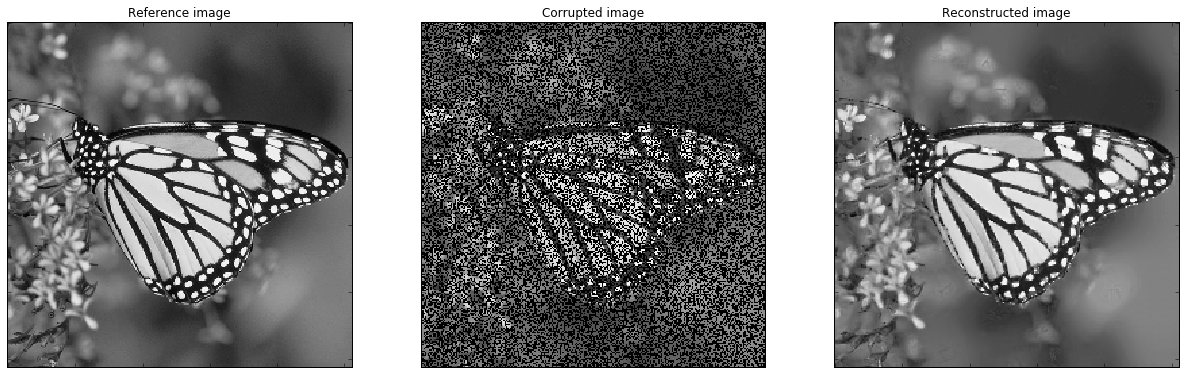

In [12]:
fig = plot.figure(figsize=(21, 7))
plot.subplot(1, 3, 1)
plot.imview(img, title='Reference image', fig=fig)
plot.subplot(1, 3, 2)
plot.imview(imgw, title='Corrupted image', fig=fig)
plot.subplot(1, 3, 3)
plot.imview(imgr, title='Reconstructed image', fig=fig)
fig.show()

Display lowpass component and sparse representation

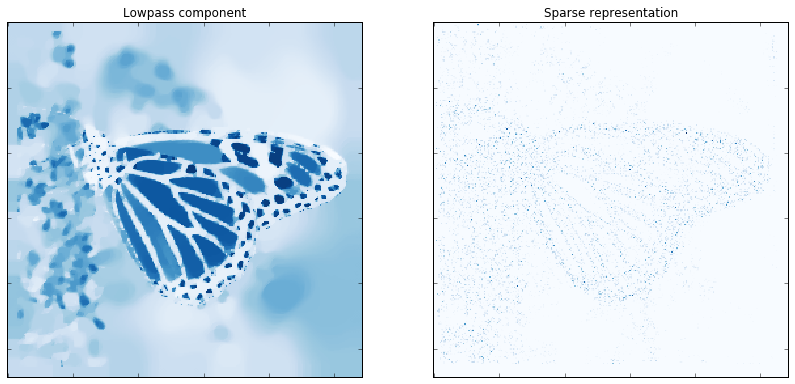

In [13]:
fig = plot.figure(figsize=(14, 7))
plot.subplot(1, 2, 1)
plot.imview(sl, cmap=plot.cm.Blues, title='Lowpass component', fig=fig)
plot.subplot(1, 2, 2)
plot.imview(np.squeeze(np.sum(abs(X), axis=b.cri.axisM)),
            cmap=plot.cm.Blues, title='Sparse representation', fig=fig)
fig.show()

Plot functional value, residuals, and rho

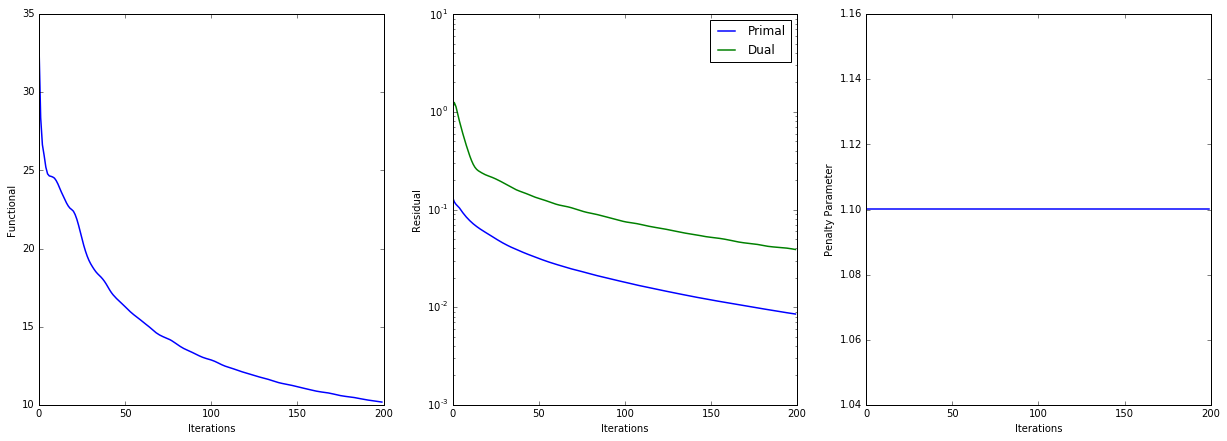

In [14]:
its = b.getitstat()
fig = plot.figure(figsize=(21, 7))
plot.subplot(1, 3, 1)
plot.plot(its.ObjFun, xlbl='Iterations', ylbl='Functional', fig=fig)
plot.subplot(1, 3, 2)
plot.plot(np.vstack((its.PrimalRsdl, its.DualRsdl)).T,
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['Primal', 'Dual'], fig=fig)
plot.subplot(1, 3, 3)
plot.plot(its.Rho, xlbl='Iterations', ylbl='Penalty Parameter', fig=fig)
fig.show()